# Optical Character Recognition and DFT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Audio

np.random.seed(2021)
seed = 2021

%matplotlib notebook
# plt.rcParams["figure.figsize"] = [16, 9]

## Image Analysis

In [2]:
from PIL import Image

In [3]:
def draw(img):
    Image.fromarray(img).show()

### Loading images

In [4]:
school_im = Image.open('lab10_school.jpg').convert('L')
fish_im = Image.open('lab10_fish1.png').convert('L')
text_im = Image.open('lab10_galia.png').convert('L')
letter_im = Image.open('lab10_galia_e.png').convert('L')

In [5]:
school = np.array(school_im)
fish = np.array(fish_im)
text = 255 - np.array(text_im)
letter = 255 - np.array(letter_im)

In [6]:
draw(school)

In [7]:
draw(text)

### Computing FFT2

In [8]:
school_fft = np.fft.fft2(school)
fish_fft = np.fft.fft2(fish)
text_fft = np.fft.fft2(text)
letter_fft = np.fft.fft2(letter)

#### Auxiliary functions

In [9]:
def normalize(X):
    return 255 * (X / np.amax(X))

In [10]:
def plot_3d(Z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    XX, YY = np.meshgrid(np.arange(Z.shape[0]), np.arange(Z.shape[1]))
    ax.plot_surface(XX, YY, Z.T, cmap='cool')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    fig.show()

#### School

<IPython.core.display.Javascript object>


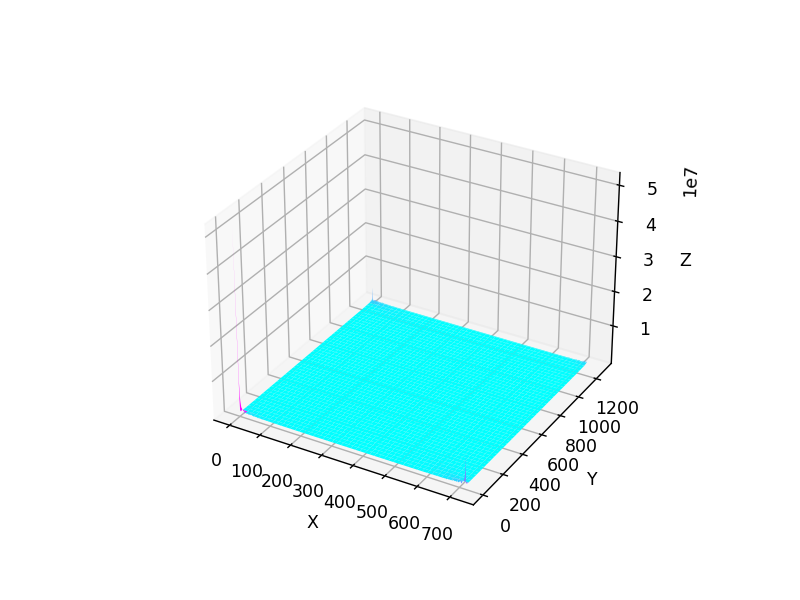

In [11]:
plot_3d(np.abs(school_fft))

<IPython.core.display.Javascript object>


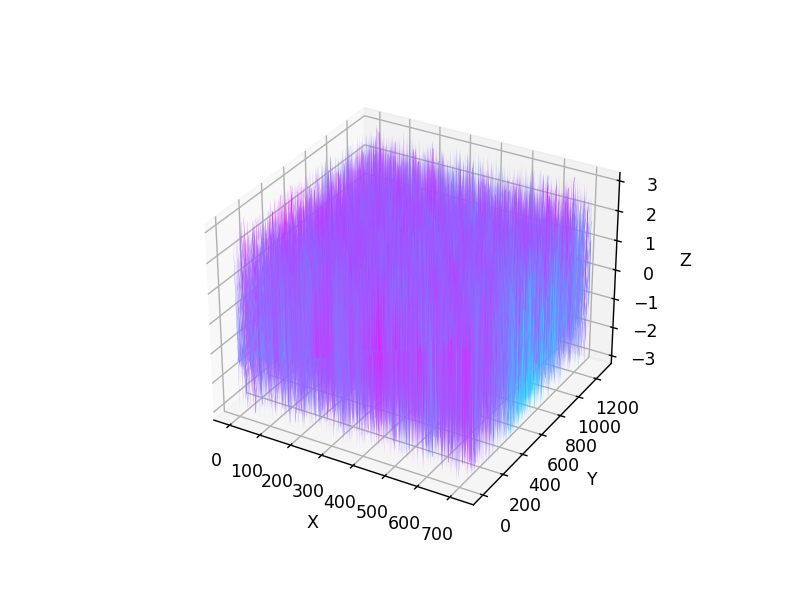

In [86]:
plot_3d(np.angle(school_fft))

#### Text

<IPython.core.display.Javascript object>


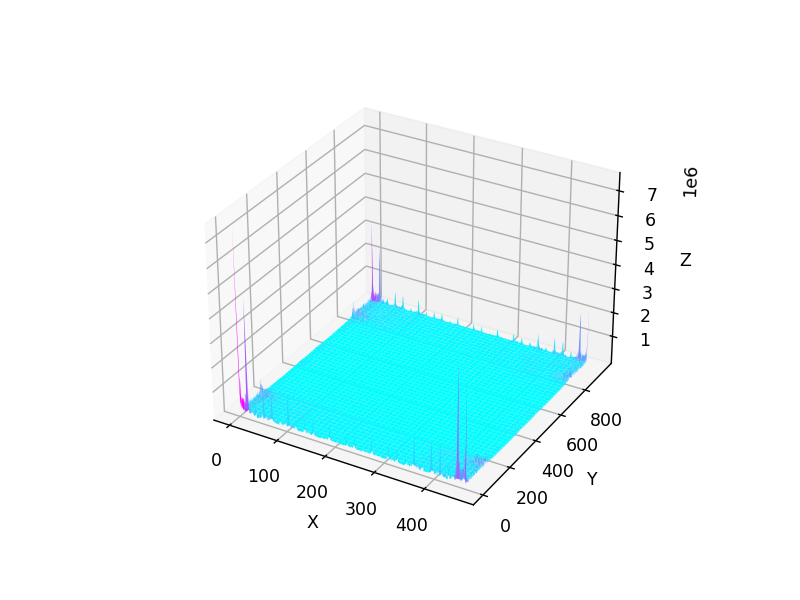

In [87]:
plot_3d(np.abs(text_fft))

<IPython.core.display.Javascript object>


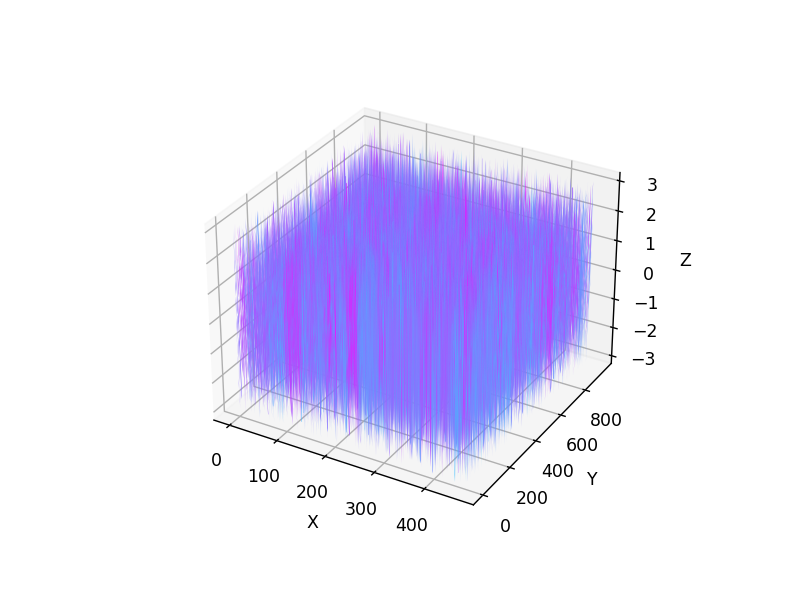

In [14]:
plot_3d(np.angle(text_fft))

### Correlation

In [4]:
def correlation(X, Y):
    assert X.ndim == 2 and Y.ndim == 2, 'X and Y must be 2-dimensional'
    assert X.shape[0] >= Y.shape[0] and X.shape[1] >= Y.shape[1], 'Y must be smaller than X'
    return np.abs(np.fft.ifft2(
        np.fft.fft2(X) * np.fft.fft2(np.rot90(Y, 2), s=X.shape)
                                    ))

In [81]:
school_corr = correlation(school, fish)

In [82]:
text_corr = correlation(text, letter)

### Analysing results

<IPython.core.display.Javascript object>


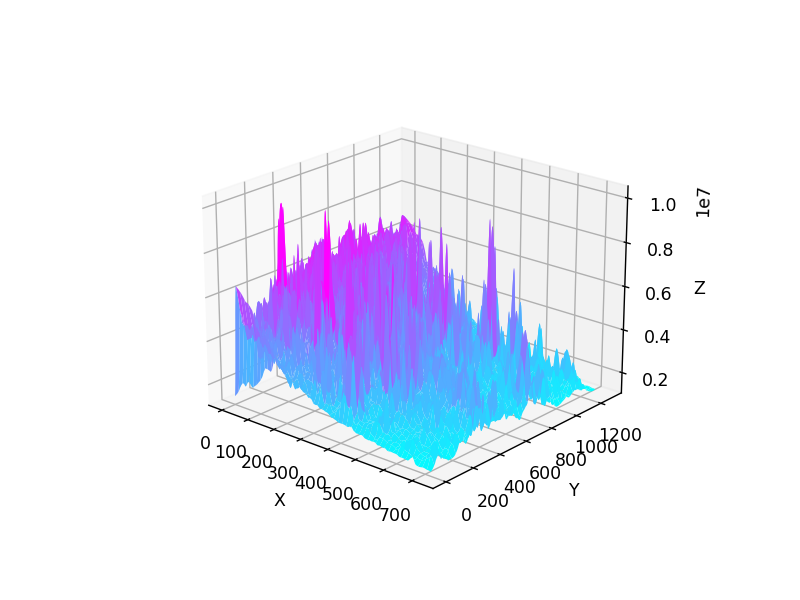

In [92]:
plot_3d(school_corr)

<IPython.core.display.Javascript object>


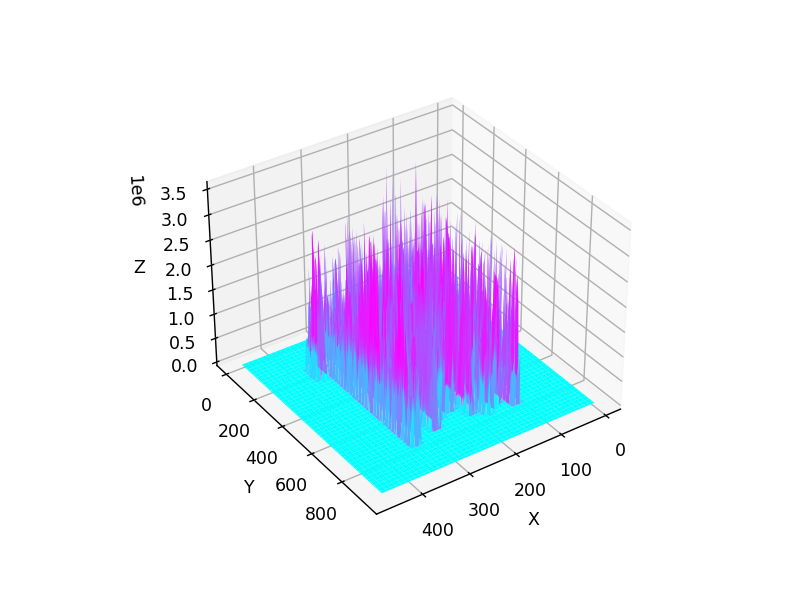

In [19]:
plot_3d(text_corr)

In [5]:
def show_match(img, corr, shape, threshold=0.9, imshow=False):
    img = img.astype(np.uint8)
    max_corr = np.amax(corr)
    matches = normalize(corr) * (corr >= threshold * max_corr)
    
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    
    matches_count = 0
    h, w = shape
    for x, y in zip(*np.where(matches)):
        img_inner = np.copy(img[x-h+2:x, y-w+2:y, :])
        # does not allow multiple matches in the same place (fixes matching for school)
        if np.any(np.sum(img_inner - np.array([[[255, 0, 0]]]), axis=2) == 0): continue
        img[x-h+1:x+1, y-w+1:y+1, :] = (255, 0, 0)
        img[x-h+2:x, y-w+2:y, :] = img_inner
        matches_count += 1
    print(f'Matches count: {matches_count}')
    if imshow:
        plt.imshow(img)
    else:
        Image.fromarray(img, mode='RGB').show()

In [122]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 9]

In [18]:
show_match(text, text_corr, letter.shape)

Matches count: 43


Matches count: 43


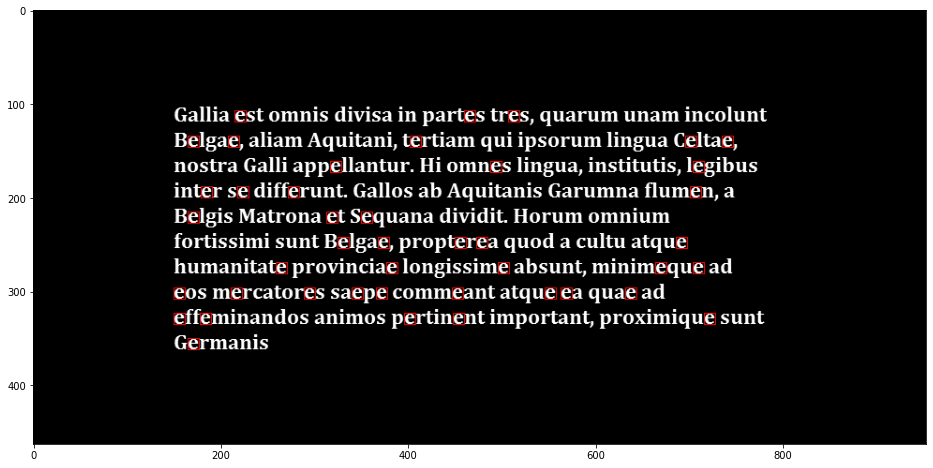

In [19]:
show_match(text, text_corr, letter.shape, imshow=True)

In [20]:
show_match(school, school_corr, fish.shape, threshold=0.7)

Matches count: 20


Matches count: 20


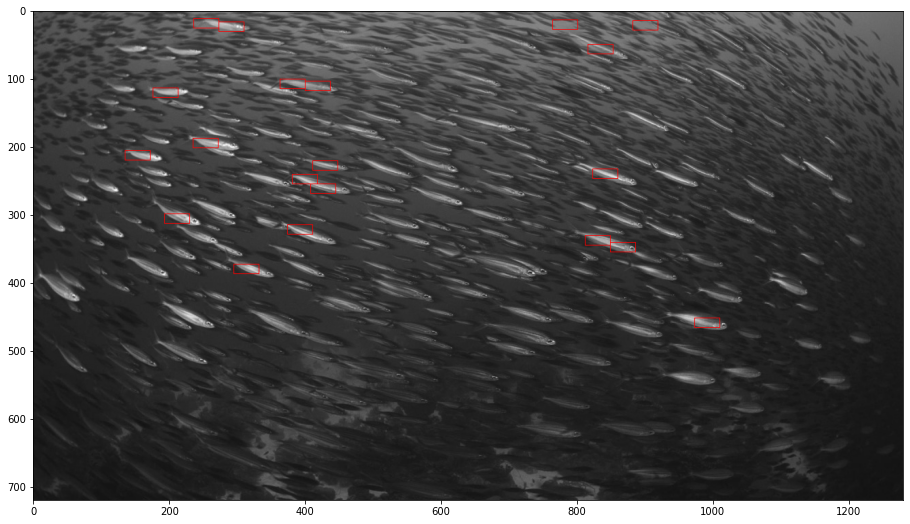

In [21]:
show_match(school, school_corr, fish.shape, threshold=0.7, imshow=True)

## OCR

### Generating images

The code below is partly taken from my side project [Subtitles Drawing](https://github.com/Goader/subtitles)

In [6]:
import os

In [7]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageOps

In [8]:
def load_font(font_name, font_size):
    fonts = {'arial':   'arial.ttf',
             'consola': 'consola.ttf',
             'constan': 'constan.ttf',
             'times':   'times.ttf'}
    try:
        font_filename = fonts[font_name]
    except KeyError:
        raise ValueError(f'Font name must be one of {list(fonts.keys())}')
    
    return ImageFont.truetype(os.path.join('fonts', font_filename), size=font_size)

In [9]:
def draw_text(text, font_name, font_size=60):
    font = load_font(font_name, font_size)

    tmp_img = Image.new('L', (1000, 1000), 255)
    overlay_size = ImageDraw.Draw(tmp_img)
    text_w, text_h = overlay_size.multiline_textsize(text, font)

    size = (int(text_w * 1.5), int(text_h * 2))
    coords = ((size[0] - text_w) // 2, (size[1] - text_h) // 2)
    
    img = Image.new('L', size, 255)
    overlay = ImageDraw.Draw(img)
    overlay.multiline_text(coords, text, fill=0, font=font, align='center')

    return img

In [10]:
def draw_letter(letter, font_name, font_size=60):
    font = load_font(font_name, font_size)

    tmp_img = Image.new('L', (1000, 1000), 255)
    overlay_size = ImageDraw.Draw(tmp_img)
    text_w, text_h = overlay_size.textsize(letter, font)
    
    img = Image.new('L', (text_w, text_h), 255)
    overlay = ImageDraw.Draw(img)
    overlay.text((0, 0), letter, fill=0, font=font, align='center')

    return img

In [11]:
def rotate(img, angle):
    return img.rotate(int(angle), expand=1, fillcolor=255, resample=Image.BICUBIC)

In [12]:
# note that if you use both rotate and negate, you should start with rotate
# because there is fillcolor in 'rotate', and there will be white stains at the edges
def negate(img):
    return ImageOps.invert(img)

#### Testing out
Note that if you use both ```rotate``` and ```negate```, you should start with ```rotate```

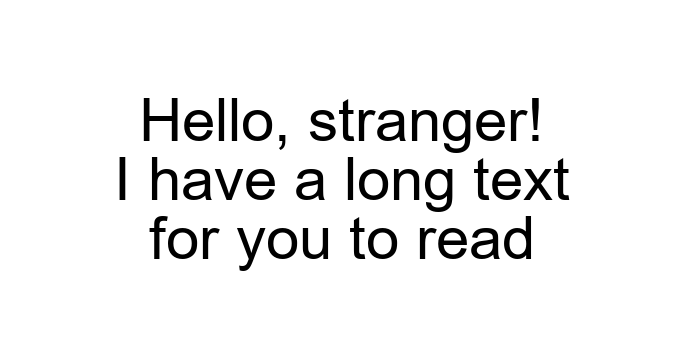

In [479]:
draw_text('Hello, stranger!\nI have a long text\nfor you to read', 'arial')

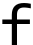

In [480]:
draw_letter('f', 'consola')

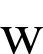

In [481]:
draw_letter('w', 'times')

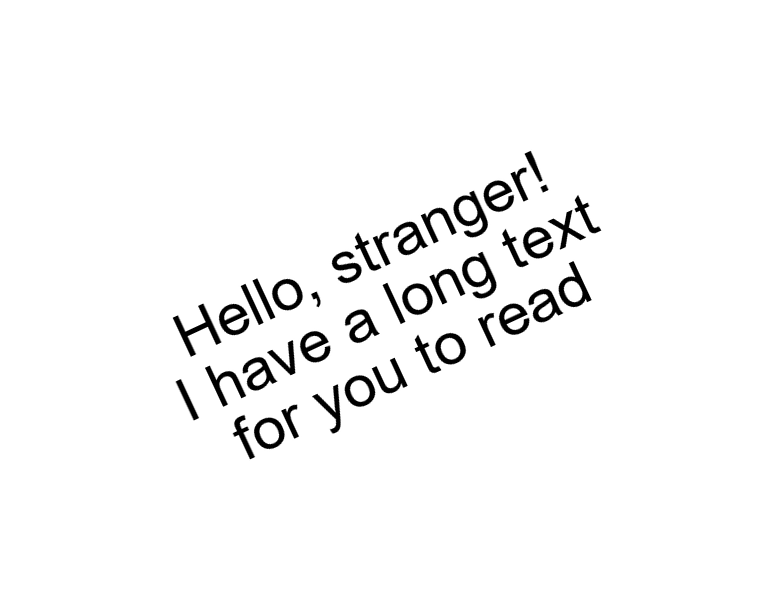

In [482]:
rotate(draw_text('Hello, stranger!\nI have a long text\nfor you to read', 'arial'), 25)

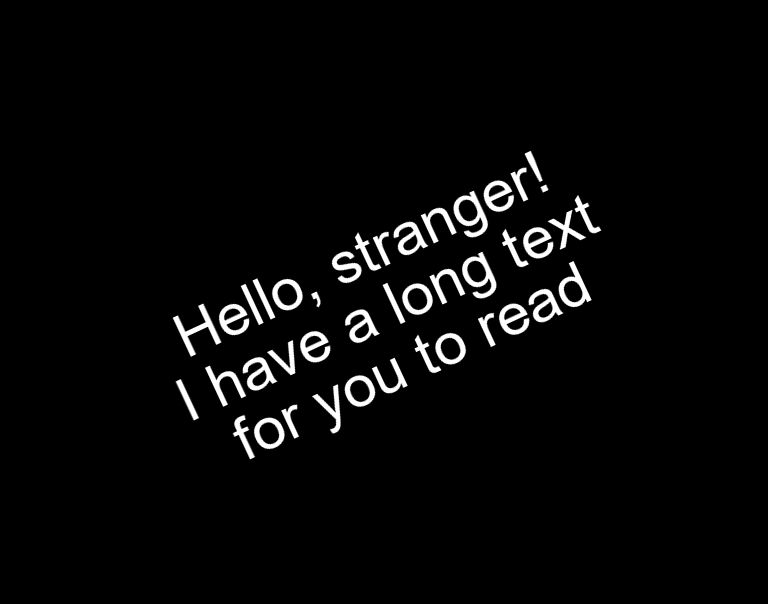

In [483]:
negate(rotate(draw_text('Hello, stranger!\nI have a long text\nfor you to read', 'arial'), 25))

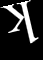

In [484]:
negate(rotate(draw_letter('k', 'times'), 193))

### Algorithm

#### Auxiliary functions

##### Skewness Correction

In [13]:
import cv2

In [14]:
# the algorithm below is based on (or rather taken from :) this article:
# https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
# btw, this blog is included in the documents scraped for the search engine (lab 8)
# so, we can assume, that I have searched for this algorithm using my search engine :D
def correct_skewness(img):
    gray = np.array(img)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    if abs(angle) > 89:
        return img  # it is rather not rotated
    return rotate(img, angle)

##### Noise

In [15]:
def explained_variance(Sig):
    return np.square(Sig) / np.sum(np.square(Sig))

In [16]:
def lowrank(A, k=None, exp_var=0.9999):
    U, D, V = np.linalg.svd(A)
    if k is None:
        k = np.searchsorted(np.cumsum(explained_variance(D)), exp_var)
    return (U[:, :k] * D[:k]) @ V[:k, :]

In [17]:
def reduce_noise(img, pillow=True):
    im = np.array(img)
    reduced = lowrank(im)
    interpolated = np.interp(reduced, [np.amin(reduced), np.amax(reduced)], [0, 255])
    if pillow:
        return Image.fromarray(interpolated.astype(np.uint8), mode='L')
    else:
        return interpolated

##### Correlations

In [18]:
def correlation_fft(X, Y):
    assert X.ndim == 2 and Y.ndim == 2, 'X and Y must be 2-dimensional'
    assert X.shape[0] >= Y.shape[0] and X.shape[1] >= Y.shape[1], 'Y must be smaller than X'
    return np.abs(np.fft.ifft2(X * np.fft.fft2(np.rot90(Y, 2), s=X.shape)))

##### Thresholds

In [19]:
import json

In [20]:
def load_thresholds():
    with open('thresholds.json') as json_file:
        thresholds = json.load(json_file)
    return thresholds

#### Optical Character Recognition

In [21]:
import string
import scipy.signal as signal
from llist import dllist
from collections import defaultdict, namedtuple

In [22]:
def ocr(img, font_name, font_size=60, threshold=0.95, debug=False):
    img = correct_skewness(img)
    
    img = negate(img)
    img = reduce_noise(img, pillow=False)
    
    img_fft = np.fft.fft2(img)
    
    thresholds = defaultdict(lambda: threshold)
    thresholds.update(**load_thresholds())
    
    # defining containers to store results
    RecognizedSymbol = namedtuple('RecognizedSymbol', ['letter', 'corr', 'w', 'h'])
    recognized = dict()  # (row, col) -> symbol
    
    symbols = string.ascii_lowercase + string.digits + '.,!?'
    for symbol in symbols:
        simg = np.array(negate(draw_letter(symbol, font_name, font_size)))
        
        corr = correlation_fft(img_fft, simg)
        max_corr = np.amax(corr)
    
        matches = corr * (corr >= thresholds[symbol] * max_corr)
        for x, y in zip(*np.where(matches)):
            recognized[(x, y-simg.shape[1])] = RecognizedSymbol(symbol, matches[x, y], 
                                                                simg.shape[1], simg.shape[0])
            
    # structuring recognized letters into rows
    imr = np.zeros(img.shape)
    for x, y in recognized.keys():
        imr[x, y] = 1
    
    recognized_per_row = np.sum(imr, axis=1)
    local_maximas = signal.argrelmax(recognized_per_row)[0]
    
    root_row = np.argmax(recognized_per_row)
    rows = dllist([root_row])
    
    # adding all the rows going down from the root_row
    down = root_row - font_size
    while down > 0:
        if np.any(np.abs(local_maximas - down) < font_size / 5):
            rows.appendleft(down)
            down = local_maximas[np.argmin(np.abs(local_maximas - down))] - font_size
        else:
            down -= font_size
        
    # adding all the rows going up from the root_row
    up = root_row + font_size
    while up < img.shape[0]:  # height
        if np.any(np.abs(local_maximas - up) < font_size / 5):
            rows.appendright(up)
            up = local_maximas[np.argmin(np.abs(local_maximas - up))] + font_size
        else:
            up += font_size
        
    # structuring rows into text
    # it would be much better to use KDTree like this https://github.com/Goader/KDTree_QuadTree
    # here to make 2d range search of points in O(logn), but adapting that code
    # (removing visualisation, and so on) would take too long, so I just used filtering
    text = []
    for row in rows:
        # use those keys, where height is different from 
        # the row height at most by half of the font size
        recognized_row = list(
            filter(lambda x: abs(x[0] - row) < font_size / 2, recognized.keys())
        )
        
        if debug:
            print(f'Row {row}')

        # first recognized symbol in row (the most left)
        offset = min(recognized_row, key=lambda x: x[1])[1]
        # last recognized symbol in row (the most right)
        max_offset = max(recognized_row, key=lambda x: x[1])[1]
        
        row_string = []
        while offset <= max_offset:
            recognized_letters = [recognized[position] for position in \
                    filter(lambda x: 0 <= x[1] - offset <= font_size / 4, recognized_row)]
            if debug:
                print(f'  Offset: {offset}')
                for l in recognized_letters:
                    print(f'    Letter: {l.letter}, corr: {l.corr}')
            if recognized_letters:
                recognized_letter = max(recognized_letters, key=lambda x: x.corr)
                row_string.append(recognized_letter.letter)
                offset += recognized_letter.w
            else:
                row_string.append(' ')
                offset += draw_letter(' ', font_name, font_size).width
        
        text.append(''.join(row_string))
    text = '\n'.join(text)
    
    if debug:
        print(f'Rows: {rows}')
        plt.imshow(imr, cmap='gray')
    
    return text

Row 139
  Offset: 140
    Letter: h, corr: 25087436.82840737
    Letter: n, corr: 22281454.114641774
    Letter: h, corr: 25088084.084167697
  Offset: 173
    Letter: e, corr: 26553646.781552643
  Offset: 206
    Letter: k, corr: 22144975.499766678
    Letter: 1, corr: 13725077.212320564
    Letter: l, corr: 13257177.847181309
    Letter: 1, corr: 13725099.970029708
  Offset: 236
  Offset: 253
  Offset: 270
  Offset: 287
    Letter: s, corr: 22724959.260667536
  Offset: 317
    Letter: t, corr: 15721701.215780187
  Offset: 334
    Letter: r, corr: 12414550.041514741
  Offset: 355
    Letter: a, corr: 24357172.763227154
    Letter: a, corr: 25016854.475557357
    Letter: a, corr: 26650740.252415273
    Letter: z, corr: 14657820.311638832
    Letter: a, corr: 24355288.92508254
    Letter: z, corr: 14635979.16658774
  Offset: 388
    Letter: n, corr: 22234694.40133045
  Offset: 421
    Letter: 8, corr: 23053840.735855617
    Letter: 9, corr: 27497434.932912536
    Letter: ?, corr: 1500179

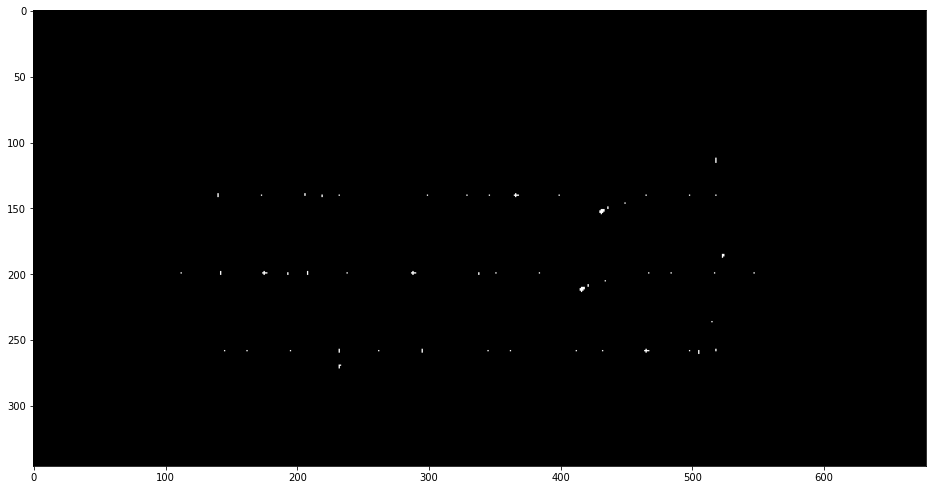

In [306]:
print(ocr(draw_text('hello, stranger!\ni have a long text\nfor you to read', 'arial'), 
          'arial', debug=True))

#### Statistics

In [23]:
import leven
from collections import Counter

In [24]:
# accuracy written using levenshtein distance
def accuracy(text, original_text):
    return max(1 - leven.levenshtein(text, original_text) / len(original_text), 0)

In [25]:
def count_letters(text):
    return Counter(text)

### Testing out

In [26]:
def test(text, font, rotated=None, show=False):
    text_img = draw_text(original_text, font)
    if rotated is not None:
        text_img = rotate(text_img, rotated)
        correct_skewness(text_img).show()
    text = ocr(text_img, font)
    print(f'Font: {font}')
    print(f'Recognized text:\n\n{text}', end='\n\n')
    print(f'Accuracy: {accuracy(text, original_text)}')
    print(f'Letters: {count_letters(text)}')

#### Arial

In [448]:
font = 'arial'

##### #1

In [449]:
original_text = \
"""hello, stranger!
i have a long text
for you to read"""

In [450]:
test(original_text, font)

Font: arial
Recognized text:

hek   stran9er!
i have a on9 text
f r you to read

Accuracy: 0.8431372549019608
Letters: Counter({' ': 11, 'e': 5, 't': 4, 'r': 4, 'a': 4, 'o': 3, 'h': 2, 'n': 2, '9': 2, '\n': 2, 'k': 1, 's': 1, '!': 1, 'i': 1, 'v': 1, 'x': 1, 'f': 1, 'y': 1, 'u': 1, 'd': 1})


##### #2

In [352]:
original_text = \
"""so, we have got a very long text here
i do not know actually what to say here,
but let's pretend it is something smart.
well, i do need to add some extra rows,
so then the text is really big"""

In [353]:
test(original_text, font)

Font: times
Recognized text:

so,we have got a very long text here
ido not 1now actualqyvv at to say here,
6utlet s pretend it is some0 ing smart
we0, i do need to add some extrarows,
sothen the text is realqy 6ig

Accuracy: 0.9
Letters: Counter({' ': 33, 'e': 21, 't': 18, 'o': 13, 's': 10, 'a': 10, 'r': 8, 'n': 7, 'i': 7, 'd': 6, 'h': 5, ',': 4, 'w': 4, 'v': 4, 'g': 4, 'y': 4, 'l': 4, '\n': 4, 'x': 3, 'm': 3, 'u': 2, 'q': 2, '6': 2, '0': 2, '1': 1, 'c': 1, 'p': 1})


##### #3

In [354]:
# 'My Testament' - Taras Shevchenko (Заповіт)
original_text = \
"""when i am dead, bury me
in my beloved ukraine,
my tomb upon a grave mound high
amid the spreading plain,
so that the fields, the boundless steppes,
the dnieper's plunging shore
my eyes could see, my ears could hear
the mighty river roar.
when from ukraine the dnieper bears
into the deep blue sea
the blood of foes ... then will i leave
these hills and fertile fields _
i'll leave them all and fly away
to the abode of god,
and then i'll pray .... but till that day
i nothing know of god.
oh bury me, then rise ye up
and break your heavy chains
and water with the tyrants' blood
the freedom you have gained.
and in the great new family,
the family of the free,
with softly spoken, kindly word
remember also me."""

In [355]:
test(original_text, font)

Font: times
Recognized text:

when i am9 ead,6ury me
inmy 6eloved u4raine,
mytom6 upon a grave mound high
amid0he spr ading plain,
sothat the fields, 0 e 6oundless steppes,
0 e dniepers plunging shore
myeyes could see, my ears could hear
0 e mighty riverroar
when fom u4raine 0hednieper 6ears
intothe deep 6lue sea
0 e 6lood offoes     0 en wiq i leave
0 ese hiqs and f rtile fields
iq leave them alq and 0y away
tothe a6ode of god,
and0hen iq  pr y      6ut tiq that day
inothing z now ofgod
oh6ury me, 0hen riseye up
and6rea4 your heavy chains
andwater wi0hthe tyrants  6lood
0 e feedom you have gained
andin 0heg reatnew family,
0 e f mily ofthe free,
wi0  so0ly spozen, zindqyvv rd
r mem6er also me

Accuracy: 0.8408450704225352
Letters: Counter({' ': 115, 'e': 76, 'a': 39, 'n': 34, 'i': 34, 'o': 34, 'd': 29, 'r': 28, 'h': 27, 's': 24, '\n': 23, 't': 23, 'y': 21, 'm': 19, 'l': 19, '0': 17, 'u': 15, '6': 13, 'f': 13, 'p': 12, ',': 11, 'g': 11, 'w': 9, 'v': 9, 'q': 7, '4': 3, 'c': 3, 'z': 3, '

##### #4
"The Mighty Dnieper" - Taras Shevchenko (Реве та стогне Дніпр широкий)

This poem has been set to music [video](https://www.youtube.com/watch?v=vvnIV3XxN-Y)

In [356]:
original_text = \
"""the mighty dnieper roars and bellows,
the wind in anger howls and raves,
down to the ground it bends the willows,
and mountain-high lifts up the waves.
the pale-faced moon picked out this moment
to peek out from behind a cloud,
like a canoe upon the ocean
it first tips up, and then dips down.
the cocks don't crow to wake the morning,
there's not as yet a sound of man,
the owls in glades call out their warnings,
and ash trees creak and creak again."""

In [357]:
test(original_text, font)

Font: times
Recognized text:

0 e mighty dnieperroars and 6e0ows,,
0 e wind in angerhowls and raves,
downto the ground it 6ends 0 e wilqows,
andmountain 1 igh li0s up 0 e waves
0 e pale f ced moon pic1ed out 0 is moment
topee1 out from 6ehind a cloud,
l4 e a canoe upon 0 e ocean
itfirst tq s up, and 0 en dq s down
0 e coczs dont crow to wa4e 0he mornin8,
0 eres not as yet a sound of man,
0 e owls in glades ca0 out 0 eir warnings,
andash trees crea1 and crea1 again

Accuracy: 0.8536585365853658
Letters: Counter({' ': 86, 'e': 38, 'n': 33, 'o': 30, 'a': 28, 's': 21, 'd': 20, 'i': 19, 't': 18, '0': 16, 'r': 16, 'w': 12, '\n': 11, 'c': 11, 'u': 10, ',': 9, 'm': 8, 'l': 8, 'g': 7, 'h': 7, 'p': 7, '1': 5, 'f': 4, '6': 3, 'q': 3, 'y': 2, 'v': 2, '4': 2, 'z': 1, '8': 1})


##### Times New Roman

In [337]:
font = 'times'

##### #1

In [338]:
original_text = \
"""hello, stranger!
i have a long text
for you to read"""

In [339]:
test(original_text, font)

Font: times
Recognized text:

be06, s6 mger!
ibawe a l6ng tezt
f r y6u t6 reaq

Accuracy: 0.6666666666666667
Letters: Counter({' ': 9, 'e': 5, '6': 5, 'r': 3, 'a': 3, 't': 3, 'b': 2, 'g': 2, '\n': 2, '0': 1, ',': 1, 's': 1, 'm': 1, '!': 1, 'i': 1, 'w': 1, 'l': 1, 'n': 1, 'z': 1, 'f': 1, 'y': 1, 'u': 1, 'q': 1})


##### #2

In [340]:
original_text = \
"""so, we have got a very long text here
i do not know actually what to say here,
but let's pretend it is something smart.
well, i do need to add some extra rows,
so then the text is really big"""

In [341]:
test(original_text, font)

Font: times
Recognized text:

so,we have got a very long text here
ido not 1now actualqyvv at to say here,
6utlet s pretend it is some0 ing smart
we0, i do need to add some extrarows,
so0hen 0 e text is rea0y 6ig

Accuracy: 0.8789473684210526
Letters: Counter({' ': 34, 'e': 21, 't': 16, 'o': 13, 's': 10, 'a': 10, 'r': 8, 'n': 7, 'i': 7, 'd': 6, '0': 5, ',': 4, 'w': 4, 'h': 4, 'v': 4, 'g': 4, 'y': 4, '\n': 4, 'l': 3, 'x': 3, 'm': 3, 'u': 2, '6': 2, '1': 1, 'c': 1, 'q': 1, 'p': 1})


##### #3

In [342]:
# 'My Testament' - Taras Shevchenko (Заповіт)
original_text = \
"""when i am dead, bury me
in my beloved ukraine,
my tomb upon a grave mound high
amid the spreading plain,
so that the fields, the boundless steppes,
the dnieper's plunging shore
my eyes could see, my ears could hear
the mighty river roar.
when from ukraine the dnieper bears
into the deep blue sea
the blood of foes ... then will i leave
these hills and fertile fields _
i'll leave them all and fly away
to the abode of god,
and then i'll pray .... but till that day
i nothing know of god.
oh bury me, then rise ye up
and break your heavy chains
and water with the tyrants' blood
the freedom you have gained.
and in the great new family,
the family of the free,
with softly spoken, kindly word
remember also me."""

In [343]:
test(original_text, font)

Font: times
Recognized text:

when i am9 ead,6ury me
inmy 6eloved u4raine,
mytom6 upon a grave mound high
amid0he spr ading plain,
sothat the fields, 0 e 6oundless steppes,
0 e dniepers plunging shore
myeyes could see, my ears could hear
0 e mighty riverroar
when fom u4raine 0hednieper 6ears
intothe deep 6lue sea
0 e 6lood offoes     0 en wiq i leave
0 ese hiqs and f rtile fields
iq leave them alq and 0y away
tothe a6ode of god,
and0hen iq  pr y      6ut tiq that day
inothing z now ofgod
oh6ury me, 0hen riseye up
and6rea4 your heavy chains
andwater wi0hthe tyrants  6lood
0 e feedom you have gained
andin 0heg reatnew family,
0 e f mily ofthe free,
wi0  so0ly spozen, zindqyvv rd
r mem6er also me

Accuracy: 0.8408450704225352
Letters: Counter({' ': 115, 'e': 76, 'a': 39, 'n': 34, 'i': 34, 'o': 34, 'd': 29, 'r': 28, 'h': 27, 's': 24, '\n': 23, 't': 23, 'y': 21, 'm': 19, 'l': 19, '0': 17, 'u': 15, '6': 13, 'f': 13, 'p': 12, ',': 11, 'g': 11, 'w': 9, 'v': 9, 'q': 7, '4': 3, 'c': 3, 'z': 3, '

##### #4
"The Mighty Dnieper" - Taras Shevchenko (Реве та стогне Дніпр широкий)

This poem has been set to music [video](https://www.youtube.com/watch?v=vvnIV3XxN-Y)

In [346]:
original_text = \
"""the mighty dnieper roars and bellows,
the wind in anger howls and raves,
down to the ground it bends the willows,
and mountain-high lifts up the waves.
the pale-faced moon picked out this moment
to peek out from behind a cloud,
like a canoe upon the ocean
it first tips up, and then dips down.
the cocks don't crow to wake the morning,
there's not as yet a sound of man,
the owls in glades call out their warnings,
and ash trees creak and creak again."""

In [345]:
test(original_text, font)

Font: times
Recognized text:

0 e mighty dnieperroars and 6e0ows,,
0 e wind in angerhowls and raves,
downto 0he groundit 6ends 0hevv 0ows,
andmountain 1 igh li0s up 0 e waves
0 e pale f ced moon pic1ed out 0 is moment
topee1 out from 6ehind a cloud,
l4 e a canoe upon 0 e ocean
itfirst tq s up, and 0 en dq s down
0 e coczs dont crow to wa4e 0he mornin8,
0 eres not as yet a sound of man,
0 e owls in glades ca0 out 0 eir warnings,
andash trees crea1 and crea1 again

Accuracy: 0.8425720620842572
Letters: Counter({' ': 84, 'e': 38, 'n': 33, 'o': 30, 'a': 28, 's': 21, 'd': 20, '0': 18, 'i': 18, 't': 17, 'r': 16, 'w': 11, '\n': 11, 'c': 11, 'u': 10, ',': 9, 'm': 8, 'h': 8, 'g': 7, 'p': 7, 'l': 7, '1': 5, 'v': 4, 'f': 4, '6': 3, 'y': 2, '4': 2, 'q': 2, 'z': 1, '8': 1})


#### Arial Rotated

In [578]:
font = 'arial'

##### #1

In [584]:
original_text = \
"""hello, stranger!
i have a long text
for you to read"""

In [585]:
test(original_text, font, rotated=25, show=True)

Font: arial
Recognized text:

helo  stm  9er!
have a ong text
f    you to mad

Accuracy: 0.7254901960784313
Letters: Counter({' ': 13, 'e': 4, 'o': 4, 't': 4, 'a': 3, 'h': 2, 'm': 2, '\n': 2, 'l': 1, 's': 1, '9': 1, 'r': 1, '!': 1, 'v': 1, 'n': 1, 'g': 1, 'x': 1, 'f': 1, 'y': 1, 'u': 1, 'd': 1})


##### #2

In [586]:
original_text = \
"""so, we have got a very long text here
i do not know actually what to say here,
but let's pretend it is something smart.
well, i do need to add some extra rows,
so then the text is really big"""

In [587]:
test(original_text, font, rotated=5, show=True)

Font: arial
Recognized text:

so  we have5,ot a ve y     g text here
do   o     ow actually what to say here
but et s p ete  d  t  s someth  9 smart
.e      do   eed to add some ext a  ows
so the   f e text  s  ea  y 65,

Accuracy: 0.7421052631578947
Letters: Counter({' ': 69, 'e': 21, 't': 17, 'o': 12, 's': 10, 'a': 10, 'h': 6, 'd': 6, 'w': 4, 'y': 4, '\n': 4, 'x': 3, 'r': 3, 'm': 3, 'v': 2, '5': 2, ',': 2, 'u': 2, 'l': 2, 'g': 1, 'c': 1, 'b': 1, 'p': 1, '9': 1, '.': 1, 'f': 1, '6': 1})


##### #3

In [588]:
# 'My Testament' - Taras Shevchenko (Заповіт)
original_text = \
"""when i am dead, bury me
in my beloved ukraine,
my tomb upon a grave mound high
amid the spreading plain,
so that the fields, the boundless steppes,
the dnieper's plunging shore
my eyes could see, my ears could hear
the mighty river roar.
when from ukraine the dnieper bears
into the deep blue sea
the blood of foes ... then will i leave
these hills and fertile fields _
i'll leave them all and fly away
to the abode of god,
and then i'll pray .... but till that day
i nothing know of god.
oh bury me, then rise ye up
and break your heavy chains
and water with the tyrants' blood
the freedom you have gained.
and in the great new family,
the family of the free,
with softly spoken, kindly word
remember also me."""

In [589]:
test(original_text, font, rotated=85, show=True)

Font: arial
Recognized text:

.he    a    deadl  bu y    e
y beovedjux  a  e
y to   b upo  a 9, ave    ou   l h9h
a   d the sp eadj  9 p a
so that the fe ds  the bou  djess steppes
the d  epe  s p u  g  9, sho e
y eyes  ou d see     y ea s  x u d hea
the    ghty   ve    oa
.he   f o    ux a   e the d  epe  bea  s
to the deep bue sea
the bood of foes     the    .      eave
these h  s a  d fe t e f e ds
eave them a  a  d f y a .ay
to the a6ode of9od
a  d tne      p  ay      but t   that day
oth  g xno  . of god
on 5u y me  the     se ye up
a  d b eax you  heavy cna   s
a  d wate  w    the ty  a  ts 6 ood
the f eedom you have 9aned
a  d n the g   at   ew fam  y
the f m7y of the f ee .
wtn softly spoxen  x ndly wo d
emem5e  as   me

Accuracy: 0.6507042253521127
Letters: Counter({' ': 271, 'e': 78, 'a': 40, 't': 38, 'o': 33, 'h': 31, 'd': 29, 's': 24, '\n': 23, 'y': 21, 'u': 15, 'f': 15, 'p': 12, 'b': 9, 'n': 9, 'm': 8, 'v': 7, 'x': 7, '.': 6, '9': 6, 'g': 5, 'w': 5, 'l': 4, 'j': 3, ',': 2,

##### #4
"The Mighty Dnieper" - Taras Shevchenko (Реве та стогне Дніпр широкий)

This poem has been set to music [video](https://www.youtube.com/watch?v=vvnIV3XxN-Y)

In [590]:
original_text = \
"""the mighty dnieper roars and bellows,
the wind in anger howls and raves,
down to the ground it bends the willows,
and mountain-high lifts up the waves.
the pale-faced moon picked out this moment
to peek out from behind a cloud,
like a canoe upon the ocean
it first tips up, and then dips down.
the cocks don't crow to wake the morning,
there's not as yet a sound of man,
the owls in glades call out their warnings,
and ash trees creak and creak again."""

In [591]:
test(original_text, font, rotated=74, show=True)

Font: arial
Recognized text:

the    9hty d   epe   oa  s a d be  o   s
the  .   d     a 9e   ho   s a  d  aves
do .   to the 9 ou  d  t be  ds the      o .s
a  d mou ta    h 9h   fts up the   aves
the pae  f ced moo   p   xed out th s    o  e  t
to peex out f o    beh  d a c oud
xe a  a  oe upo   the o x a
t f st t ps up  a  d the   d ps do .
the  o  xs do   t c ow to  .axe the mo      g
the es   ot as yet a sou  d of ma
the ows     9 ades   a  out the    . a     gs
a  d ash t ees    eax a  d c eax a9a

Accuracy: 0.5942350332594235
Letters: Counter({' ': 216, 'e': 37, 't': 32, 'o': 30, 'a': 28, 's': 21, 'h': 20, 'd': 20, '\n': 11, 'u': 10, 'p': 9, 'x': 8, '9': 6, '.': 6, 'f': 5, 'm': 4, 'c': 4, 'b': 3, 'y': 2, 'v': 2, 'w': 2, 'g': 2})


##### Times New Roman Rotated

In [592]:
font = 'times'

##### #1

In [593]:
original_text = \
"""hello, stranger!
i have a long text
for you to read"""

In [594]:
test(original_text, font, rotated=25, show=True)

Font: times
Recognized text:

6e06, s6 m8e  !
ihawe a l6n8 text

Accuracy: 0.3921568627450981
Letters: Counter({' ': 7, '6': 4, 'e': 4, '8': 2, 'a': 2, 't': 2, '0': 1, ',': 1, 's': 1, 'm': 1, '!': 1, '\n': 1, 'i': 1, 'h': 1, 'w': 1, 'l': 1, 'n': 1, 'x': 1})


##### #2

In [595]:
original_text = \
"""so, we have got a very long text here
i do not know actually what to say here,
but let's pretend it is something smart.
well, i do need to add some extra rows,
so then the text is really big"""

In [596]:
test(original_text, font, rotated=5, show=True)

Font: times
Recognized text:

so,we have got a very long text here
ido not 1now actualqyvv at to say here,
6utlet s pretend it is some0 ing smart
we0, i do need to add some extrarows
sothen the text is realqy 6ig

Accuracy: 0.8947368421052632
Letters: Counter({' ': 33, 'e': 21, 't': 18, 'o': 13, 's': 10, 'a': 10, 'r': 8, 'n': 7, 'i': 7, 'd': 6, 'h': 5, 'w': 4, 'v': 4, 'g': 4, 'y': 4, 'l': 4, '\n': 4, ',': 3, 'x': 3, 'm': 3, 'u': 2, 'q': 2, '6': 2, '0': 2, '1': 1, 'c': 1, 'p': 1})


##### #3

In [597]:
# 'My Testament' - Taras Shevchenko (Заповіт)
original_text = \
"""when i am dead, bury me
in my beloved ukraine,
my tomb upon a grave mound high
amid the spreading plain,
so that the fields, the boundless steppes,
the dnieper's plunging shore
my eyes could see, my ears could hear
the mighty river roar.
when from ukraine the dnieper bears
into the deep blue sea
the blood of foes ... then will i leave
these hills and fertile fields _
i'll leave them all and fly away
to the abode of god,
and then i'll pray .... but till that day
i nothing know of god.
oh bury me, then rise ye up
and break your heavy chains
and water with the tyrants' blood
the freedom you have gained.
and in the great new family,
the family of the free,
with softly spoken, kindly word
remember also me."""

In [598]:
test(original_text, font, rotated=85, show=True)

Font: times
Recognized text:

when i am9 ead 6ury me
inmy 6eloved u4raine
mytom6 upon a grave mound high
amid0he spr ading plain
sothat the fields, 0 e 6oundless steppes,
0 e dniepers plunging shore
myeyes could see  my ears could hear
0 e mighty riverroar
when fom u4raine 0hednieper 6ears
intothe deep 6lue sea
0 e 6lood offoes     0 en wi0 i leave
0 ese hiqs and f rtile fields
i0 leave them alq and 0y away
tothe a6ode of god,
and0hen iq  pr y      6ut ti0 that day
inothing xnow of god
oh6ury me, 0hen riseye up
and6rea4 your heavy chains
andwater wi0hthe tyrants  6lood
0 e feedom you have gained
andin 0heg reatnew family.
0 e f mily ofthe free,
wi0  so0ly spozen  xindly word
r mem6er also me

Accuracy: 0.8422535211267606
Letters: Counter({' ': 118, 'e': 76, 'a': 39, 'o': 35, 'n': 34, 'i': 34, 'd': 29, 'r': 28, 'h': 27, 's': 24, '\n': 23, 't': 23, 'y': 21, 'l': 20, '0': 20, 'm': 19, 'u': 15, '6': 13, 'f': 13, 'p': 12, 'g': 11, 'w': 10, 'v': 7, ',': 5, '4': 3, 'c': 3, 'q': 3, 'x': 2, '9'

##### #4
"The Mighty Dnieper" - Taras Shevchenko (Реве та стогне Дніпр широкий)

This poem has been set to music [video](https://www.youtube.com/watch?v=vvnIV3XxN-Y)

In [322]:
original_text = \
"""the mighty dnieper roars and bellows,
the wind in anger howls and raves,
down to the ground it bends the willows,
and mountain-high lifts up the waves.
the pale-faced moon picked out this moment
to peek out from behind a cloud,
like a canoe upon the ocean
it first tips up, and then dips down.
the cocks don't crow to wake the morning,
there's not as yet a sound of man,
the owls in glades call out their warnings,
and ash trees creak and creak again."""

In [600]:
test(original_text, font, rotated=74, show=True)

Font: times
Recognized text:

0 e n  8hty d   epe    oa s a  d be0o   s.
0 e  vi d   na  8 e  ho v s a  d  aves,
dow  to 0he 8 ou5d  t 6ends 0 e     0o   s
andn  ountai   h 8h 1fts up 0 e    a  es
0 e pa e fa ed n oon p   xed out 0  s n  o   e  t
topeex out f o    behi  d a   1 ud.
1xe a canoe upo   0 e ocea
itfi st tqp .up  a  d 0 en dq s dov
0 e cocxs do  t c  ov to v a4e 0he    o7    g
0 e e s   ot as yet a sou  d ofn a  ,
0 e owls i   8lades  a0  out 0 ei  war     8s
andash t  ees   reaxa  d crea4 a8a  n

Accuracy: 0.5631929046563193
Letters: Counter({' ': 197, 'e': 38, 'o': 29, 'a': 29, 'd': 20, 's': 20, 't': 18, '0': 17, 'n': 14, '\n': 11, 'u': 10, 'h': 8, 'p': 8, '8': 7, 'i': 7, 'v': 6, 'c': 6, 'f': 5, 'x': 5, '.': 3, 'w': 3, '1': 3, 'r': 3, 'y': 2, 'b': 2, ',': 2, 'q': 2, '4': 2, 'l': 2, '5': 1, '6': 1, '7': 1, 'g': 1})


As we can see, we get not the best results here. Some pictures are still skewed a little, and the skewness correction above has a serious drawback: it only allows a rotation only as $\phi \in [0, 90]$. Below, I have presented another algorithm, which will not be used, though.

The idea used below I have found at StackOverflow (what a surprise! :D). This GIF illustrates the way this method works.

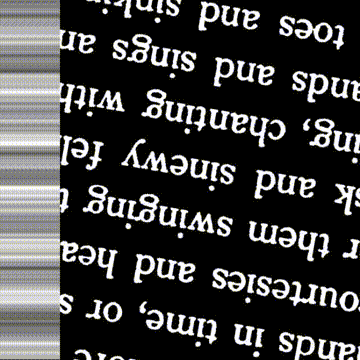

So, we simply rotate a picture, until the count of boundary black pixels is the greatest.

The only problem, that appears is a high chance of rotating the image in the way, that it turns out to be flipped at the end.

In [27]:
def correct_skewness_v2(img):
    angles_scores = np.full(360, np.inf)
    
    for i in range(360):
        im = (np.array(rotate(img, i)) > 127).astype(np.uint8)
        boundary = np.amax(im, axis=1)
        
        # not taking into consideration boundary upper black pixels, and lower ones,
        # because there may be more of them because of rotating with expanding
        nonzero = np.nonzero(boundary)
        start = nonzero[0][0]
        end = nonzero[0][-1]
        
        angles_scores[i] = np.mean(boundary[start:end])
    
    # argmin, because black pixel is 0, and white is 1 here
    return rotate(img, np.argmin(angles_scores))

I haven't found a proper way to handle this problem. The only thing I have seen is using Tesseract OCR to estimate angle. But using OCR to build an OCR is cheating! Truth to be told, I have had some troubles using it, so I have left it as it is :) \*whispers\* but shhh..

# FFT Results

To sum up, the results are quite good, but not the best we could expect. Some transformations - such as using a low-rank approximation to reduce noise (in fact, there is nothing to reduce, because we get perfectly drawn pictures, it's not a scan of a document, but this helps us simulate some noises, as we almost never get perfect pictures, for example, JPEG compresses the image using DCT - discrete cosine transformation, which is also used for perceptual image hashing - [phash](https://www.phash.org/)). The other thing that affects results - is skewness.

#### Correlation

The major problem in FFT usage for OCR is that it is great for detecting a specific character in a text, but it is not that great for classifying every symbol in a text, as there simply appear conflicts. For example, dot (```.```) has a strong correlation with almost any character, the same happens with different 'line' characters like ```i```, ```l```, ```1```, etc. They easily correlate with each other, and characters like ```t```, ```b```, ```d```, ```k```, ```h```, and so on... Therefore we have to resolve these conflicts by selecting only one, and it is a very difficult decision to make without any additional analysis (like classifying the part with conflicts using some model).

#### Row division

Another thing that can result in a problem is detecting rows. In my case, I achieved quite great results. Since I've programmed the correlation function the way, that it returns the value in the lower-right pixel of the pattern, and then writing it as the lower-left pixel (I will explain the side later, but what matters now is **lower** pixel), I could aggregate the places, where I have found the highest correlations, and use that as the marker of rows. 

My intuition lays in the following - since the letters are arranged into rows, and they are horizontal, then there will be lots of recognized letters in one row, and the highest correlation values are likely to be written in a single row, so by detecting the rows with the most pixels indicating correlation, I can assume that it is a row in the text because there are not many other reasons for the algorithm to find multiple correlations in a one-pixel row.

Having the font size and the possible positions of the row, I define a root row, which is the one, where the most correlations have been found. I claim, that since there are a lot of them, there is almost no chance it's some kind of noise or something. Then I move up and down by ```font_size``` and seek in the neighborhood for peaks of aggregated correlations. If there is one, I say: "Hey, I have found another row. Let's add it to the doubly linked list of rows, and continue moving from its position upwards or downwards". 

There is an image in the result of the cell right after the algorithm. This image has white pixels - pixels where correlation has been found (I will call them indicating pixels from now). Those are aggregated to the left row by row.

#### Character recognition

So after having the indices of all the rows, we process them one by one, adding ```\n``` between them.

Each row can be processed using KDTree and range search to do it efficiently (as in [this implementation](https://github.com/Goader/KDTree_QuadTree)), but I have used simply ```filter```, because my code of KDTree could take too long to adapt. I simply search for the first pixel indicating a correlation. Then based on the ```font_size```, I search the nearest neighborhood searching for other correlations. After this, I choose the one with the greatest value.

That's the place where the transformation described above plays a huge role: setting a lower-**left** pixel to indicate a correlation instead of lower-right. It solves one problem - if we had the right pixel as an indicating one, we would not know how far to search for correlations. For example, consider the words ```wonder``` and ```list```. In the first one to find a pixel indicating a correlation with ```w```, we would need to go lots of pixels to the right. Having the same approach for the second word, we would pass both ```li```. So there would be a problem with how to divide a long letter from a few short ones.

After this transformation, indicating pixels both for `w` and `l` will be at the same position. So our algorithm is: 
  * search for the closest neighborhood starting from a given `offset` (initially the most left indicating pixel) - if there is a letter that might start here - its indicating pixel is somewhere around
  * after selecting a letter get its pixel width, increase `offset`, and go to step 1
  * in case of no indicating pixels in the closest neighborhood - we assume there is a space character, so we add it to the final results, calculate what width does space take for given `font_name` and `font_size`, and increase `offset` by it

#### Results

_**By skewness:**_

I have implemented 2 functions for skewness correction, but none of them works fine all the time and is robust to any specific case.

The problem with the first one (finding the rectangular with the minimal area) is that for relatively small texts it may strongly depend on what the letters are (for example low letters at the start like `e`, `x`, etc, and high letters at the end like `l`, `h`, `k`, ... can affect the skewness, leaving a small angle of it.

Another problem, which is even worse - we can successfully turn a skewed text into one, that is rotated either by 0, 90, 180, or 270 degrees, and we know that the resulting image is correct, only if the initial rotation was in the [0, 90] degrees interval. I have used this for testing.

The second algorithm can result in a flipped text, but it can be more easily fixed (I explain the idea in the Machine Learning OCR Results).

_**With/without serifs:**_

This is an interesting one. At first, my intuition was that FFT is something that behaves in a different way than machine learning model. By saying this, I mean that the more pixels are used - the more correct results FFT will give, as it will have more pixels to hook up to (as it reacts to nonzero values). And in a machine learning model, it is usually not true, the more pixels we have - the more likely they are less informative.

So I expected, that fonts with serifs would give better results than the ones without, but as it appeared it didn't affect the results a lot. Even more, the results for the font without serifs gave us better results.

I suspect, this is because having more white pixels can lead to more fake positives, so the overall result is not that good. My other suspicion is that font with serifs should improve the results of a one-character search, though.

Another reason, which most likely has a major effect, is that I am using different thresholds for some problem-making characters. So what's about it? The thing is I have tuned them to get better results for Arial font, but I have not changed any of them for the Times New Roman font. So, the best way to test it would be creating another JSON file with thresholds tuned for Times New Roman, and then, in my opinion, the results for a font with serifs will improve a lot.

_**Overall:**_

I have used Levenshtein distance to measure the accuracy of the result. It is defined as $max(0, 1 - \frac{levenshtein(text, original\_text)}{len(original\_text)})$. So, mostly for our algorithm, we get accuracy from [0.8, 0.9] range. For some cases, it drops severely, for example, for initially rotated pictures.

I cannot say that this accuracy is good enough for the OCR to be used, but still, it indicates, that we've achieved quite not bad results. It can still be improved with customizing thresholds to eliminate confusions between `g` and `9` for example. Another improvement can be using patterns that start at the same height (which means that indicating pixels will be at the top of the patterns, so then we can decrease our neighborhood while searching, and this will lead to fewer false positives). Or as another approach, we can use a classification model at the spots with lots of indicating pixels.

---

# OCR using Machine Learning

In [222]:
import pandas as pd

## Loading data

Found at [UCI Repository](https://archive.ics.uci.edu/ml/datasets/Character+Font+Images)

Downloaded from [here](http://lyman.house/download/fonts_all.zip) (takes almost 1GB, but contains lots of other fonts)

In [223]:
arial = pd.read_csv('ARIAL.csv')

In [19]:
arial.columns[:20]

Index(['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation',
       'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w', 'r0c0', 'r0c1',
       'r0c2', 'r0c3', 'r0c4', 'r0c5', 'r0c6', 'r0c7'],
      dtype='object')

In [20]:
arial

font fontVariant  m_label  strength  italic  orientation  m_top  \
0       ARIAL     scanned       48  0.000000       0          0.0      0   
1       ARIAL     scanned       50  0.000000       0          0.0      0   
2       ARIAL     scanned       83  0.000000       0          0.0      0   
3       ARIAL     scanned       48  0.000000       0          0.0      0   
4       ARIAL     scanned       54  0.000000       0          0.0      0   
...       ...         ...      ...       ...     ...          ...    ...   
181804  ARIAL       ARIAL       37  0.777778       1          0.0     32   
181805  ARIAL       ARIAL       36  0.777778       1          0.0     30   
181806  ARIAL       ARIAL       35  0.777778       1          0.0     33   
181807  ARIAL       ARIAL       34  0.777778       1          0.0     33   
181808  ARIAL       ARIAL       33  0.777778       1          0.0     33   

        m_left  originalH  originalW  ...  r19c10  r19c11  r19c12  r19c13  \
0            0         15         25  ...     255     255     255     154   
1            0         18         11  ...     213     225     229     239   
2            0         13         10  ...     255     255     255     255   
3            0         15         18  ...       1       1       1       1   
4            0         14         30  ...     255     255     255     255   
...        ...        ...        ...  ...     ...     ...     ...     ...   
181804      26         50         52  ...       1       1      16     161   
181805      24         58         36  ...       1       1       1       1   
181806      23         48         37  ...     255     255     253      77   
181807      30         17         24  ...      43     255     255     255   
181808      24         48         19  ...      23       1       1       1   

        r19c14  r19c15  r19c16  r19c17  r19c18  r19c19  
0            1       1       1       1       1       1  
1          240     240     221     209     116      95  
2          255     255       1       1       1       1  
3            1       1       1       1       1       1  
4            1       1       1       1       1       1  
...        ...     ...     ...     ...     ...     ...  
181804     255     255     208      83       4       1  
181805       1       1       1       1       1       1  
181806       1       1       1       1       1       1  
181807     255     213       1       1       1       1  
181808       1       1       1       1       1       1  

[181809 rows x 412 columns]

In [536]:
(arial['font'] == 'ARIAL').count()

181809

In [676]:
arial['m_label'].value_counts()

48       1306
51       1204
49       1146
55        866
50        822
         ... 
1539        2
64439       2
1888        2
1787        2
1879        2
Name: m_label, Length: 39609, dtype: int64

Too many, we don't need all of them!

In [224]:
arial2 = arial.loc[arial['m_label'] < 128]

In [680]:
arial2['m_label'].value_counts()

48     1306
51     1204
49     1146
55      866
50      822
       ... 
59       27
61       26
124      22
39       22
95       20
Name: m_label, Length: 94, dtype: int64

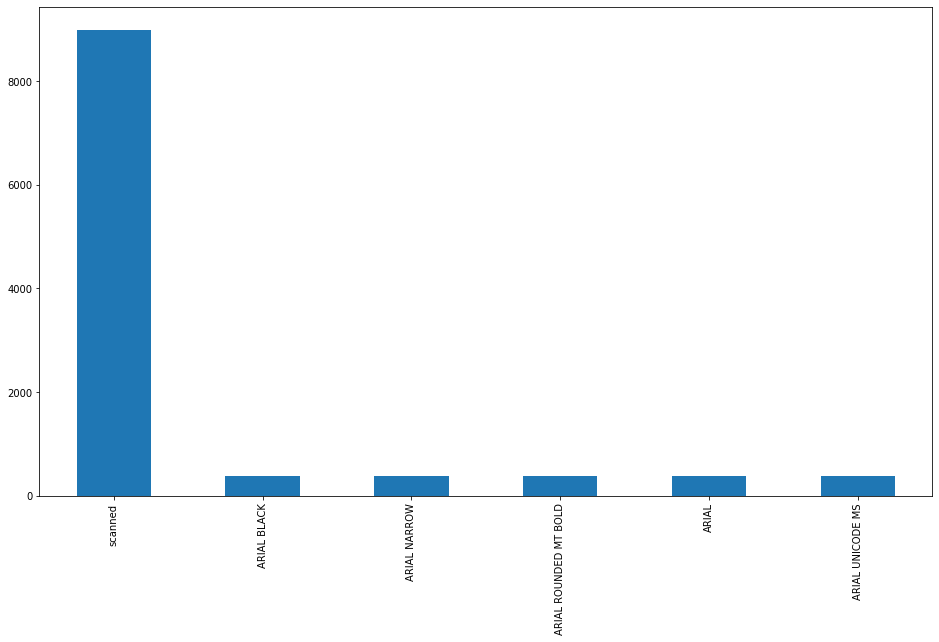

In [681]:
arial2['fontVariant'].value_counts().plot(kind='bar')
plt.show()

### Defining data

In [225]:
X = arial2.iloc[:, 12:]

In [683]:
X

r0c0  r0c1  r0c2  r0c3  r0c4  r0c5  r0c6  r0c7  r0c8  r0c9  ...  \
0          1     1     1     1     1     1   154   255   255   255  ...   
1          4     7    22    49    97   120   139   156   162   171  ...   
2          1     1     1     1   255   255   255   255   255   255  ...   
3          1     1     1     1     1   114   255   255   255   255  ...   
4          1     1     1     1     1     1     1     1   255   255  ...   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
181804     1     4    83   208   255   255   161    16     1     1  ...   
181805     1     1     1     1     1     1     1     1     1     1  ...   
181806     1     1     1     1     1     1    77   253   255   255  ...   
181807    43   255   255   255   255   255   255   255   255    43  ...   
181808     1     1     1     1     1     1     1     1     1    23  ...   

        r19c10  r19c11  r19c12  r19c13  r19c14  r19c15  r19c16  r19c17  \
0          255     255     255     154       1       1       1       1   
1          213     225     229     239     240     240     221     209   
2          255     255     255     255     255     255       1       1   
3            1       1       1       1       1       1       1       1   
4          255     255     255     255       1       1       1       1   
...        ...     ...     ...     ...     ...     ...     ...     ...   
181804       1       1      16     161     255     255     208      83   
181805       1       1       1       1       1       1       1       1   
181806     255     255     253      77       1       1       1       1   
181807      43     255     255     255     255     213       1       1   
181808      23       1       1       1       1       1       1       1   

        r19c18  r19c19  
0            1       1  
1          116      95  
2            1       1  
3            1       1  
4            1       1  
...        ...     ...  
181804       4       1  
181805       1       1  
181806       1       1  
181807       1       1  
181808       1       1  

[10864 rows x 400 columns]

In [226]:
X = np.array(X, dtype=np.uint8)

In [227]:
X.shape

(10864, 400)

In [228]:
y = np.array(arial2['m_label'], dtype=np.uint8)

In [229]:
y.shape

(10864,)

## OCR

The biggest problem here is to divide a text into characters. This can be done using a method for skewness correction presented above. Firstly, by finding black gaps we will divide a text into rows. And then doing the same thing for columns, we will divide text into characters.

Some examples of rows produced by algorithm below:

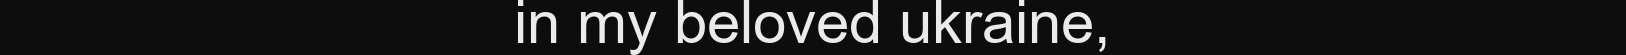
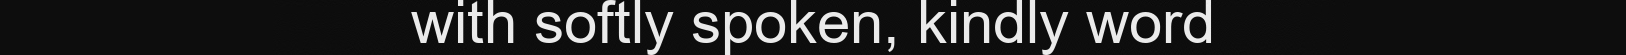

And some examples of letters:

m | d | , | y
- | - | - | -
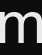 |  |  | 

There might appear a problem with fonts, which do not have at least one-pixel-wide gap between letters, but it seems Arial has one. Let's try it out.

We will take into account only not skewed texts.

In [206]:
def trim(img):
    h, w = img.shape
    
    rboundary = np.amax((img > 127).astype(np.uint8), axis=1)
    cboundary = np.amax((img > 127).astype(np.uint8), axis=0)
    
    rnonzero = np.nonzero(rboundary)
    rstart = rnonzero[0][0]
    rend = rnonzero[0][-1]
    
    cnonzero = np.nonzero(cboundary)
    cstart = cnonzero[0][0]
    cend = cnonzero[0][-1]
    
    return img[rstart:rend, cstart:cend]

In [207]:
def process_char(img):
    h, w = img.shape
    coef = 20 / max(h, w)
    if h > w:
        new_size = (int(coef * w), 20)
    else:
        new_size = (20, int(coef * h))
    
    pil_img = Image.fromarray(img.astype(np.uint8), mode='L')
    pil_img = pil_img.resize(new_size, resample=Image.BICUBIC)
#     pil_img = pil_img.resize((20, 20), resample=Image.BICUBIC)

    img = np.array(pil_img, dtype=np.uint8)
    h, w = img.shape
    
    pad_h = (20-h) // 2
    pad_w = (20-w) // 2
    img = np.pad(img, [(pad_h, 20-pad_h-h), (pad_w, 20-pad_w-w)])
    
    return img

In [208]:
def predict(img, model):
    img = trim(img)
    img = process_char(img)
    
    predicted = model.predict(img.reshape((1, -1)))
    
    return chr(predicted)

In [283]:
def ocr_ml(img, model):
    img = negate(img)
    img = reduce_noise(img, pillow=False)
    
    rows = []
    im = (img > 127).astype(np.uint8)  # only for boundary, original values still in img
    boundary = np.amax(im, axis=1)
    start = np.nonzero(boundary)[0][0]
        
    # while at least 1 white pixel in the boundary
    while True:
        # + start, because we are starting at 'start'
        end = np.where(boundary[start:] == 0)[0][0] + start
        
        # omitting possible noises
        if end - start > 5:
            rows.append(img[start:end, :])
        
        if not np.any(boundary[end:]):
            break
        start = np.nonzero(boundary[end:])[0][0] + end
    
    letters_found = 0
    average_width = 0
    
    text = []
    for row in rows:
        row_string = []
        
        rboundary = np.amax((row > 127).astype(np.uint8), axis=0)
        start = np.nonzero(rboundary)[0][0]
        end = start
        
        # while at least 1 white pixel in the boundary
        while True:
            # remembering last end: this does not react to noises
            # therefore, noises won't interfere spaces recognition
            last_end = end
            # + start, because we are starting at 'start'
            end = np.where(rboundary[start:] == 0)[0][0] + start

            # omitting possible noises
            if end - start > 3:
                last_end = end
                
                average_width = (average_width * letters_found + (end - start)) \
                                / (letters_found + 1)
                letters_found += 1
                row_string.append(predict(row[:, start:end], model))
                
            if not np.any(rboundary[end:]):
                break
            start = np.nonzero(rboundary[end:])[0][0] + end
            
            if start - last_end > average_width / 2:
                row_string.append(' ')
        
        # strip in case of noises at start, then we will add some redundant spaces
        text.append((''.join(row_string)).strip())
    text = '\n'.join(text)
        
    return text

## Training the model

In [230]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Random Forest

In [231]:
from sklearn.ensemble import RandomForestClassifier

#### Training

In [692]:
params = {'n_estimators': [50, 100, 200, 400],
          'max_depth': [5, 8, 15, 24, 30, 50, 100],
          'max_features': ['auto', 20, 50, 100, 200]
         }

grid = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed: 62.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [693]:
grid.best_score_

0.9663733631608086

In [694]:
grid.best_params_

{'max_depth': 24, 'max_features': 'auto', 'n_estimators': 400}

##### Test set

In [696]:
accuracy_score(grid.best_estimator_.predict(X_test), y_test)

0.9679675994108984

#### Application

In [232]:
# parameters from grid.best_params_ (If you restart kernel, you'll lose that variable)
# so I typed in them directly
rfclf = RandomForestClassifier(n_estimators=400, max_features='auto', max_depth=24, n_jobs=-1)
rfclf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [233]:
img = draw_text(original_text, 'arial')

In [234]:
text = ocr_ml(img, rfclf)
print(text)

Iye m. 1yi1 .n. e7eI I0aIS an. 5e. . 0wSI
Iye W. n. . n a01eI y0W. S an. IaVeSI
.0wn I0 iye 1I0Un. . i 5en.S iye w. . . 0WSI
an. m0Unia. n-y. 1y . . 1S U7 iye WaVeSi
iye 7a. e-mCe. m00n 7. C1e. 0Ui iy. S m0meni
i0 7ee1 0Ui II0m 5ey. n. a C. 0U.I
. . 1e a Can0e U70n Iye 0Cean
. i I. ISi i. 7S U7I a0. iyen .. 7S .0Wni
Iye C0C1S .00Ii CI0Wi0 Wa1e iye m0In. 01I
iyeIeI S n0i aS 1ei a S0Un. 0I manI
Iye 0w. S . n 1. a.eS Ca. . 0Ui iye. I waIn. 01SI
an. aSy IIeeS CIea1 an. CIea1 a1a. ni


### Softmax Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

#### Training

In [40]:
# l1 regularization to set zero weight to boundary pixels
# l2 regularization to make the cost function - convex, so SGD works just fine
params = {'penalty': ['elasticnet'],
          'l1_ratio': [0, 0.15, 0.25, 0.5],
          'C': [1, 3, 6, 10, 15, 20, 50, 100, 400],
          'multi_class': ['multinomial'],
          'solver': ['saga']
         }

grid = GridSearchCV(LogisticRegression(), params, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 107.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 139.7min finished
C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 3, 6, 10, 15, 20, 50, 100, 400],
                         'l1_ratio': [0, 0.15, 0.25, 0.5],
                         'multi_class': ['multinomial'],
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scorin

In [41]:
grid.best_score_

0.9658815864300052

In [42]:
grid.best_params_

{'C': 1,
 'l1_ratio': 0,
 'multi_class': 'multinomial',
 'penalty': 'elasticnet',
 'solver': 'saga'}

##### Test set

In [43]:
accuracy_score(grid.best_estimator_.predict(X_test), y_test)

0.9591310751104566

#### Application

In [235]:
# parameters from grid.best_params_ (If you restart kernel, you'll lose that variable)
# so I typed in them directly
softmaxclf = LogisticRegression(C=1, penalty='l2', solver='saga', 
                                multi_class='multinomial', n_jobs=-1)
softmaxclf.fit(X, y)

C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [237]:
img = draw_text(original_text, 'arial')

In [238]:
text = ocr_ml(img, softmaxclf)
print(text)

I5e ~. g5I. 4n. egef f0afS an4 5e+ + 0-SI
I5e -. n4 . n angef 50-+ S an4 faVeSI
40-n I0 I5e gf0un4 . I 5en4S I5e -. + + 0-SI
an4 ~0unIa. n-5. g5 + . xS ug I5e -aVeSl
I5e ga+ e-0ce4 ~00n g. cie4 0uI I5. S ~0~enI
I0 geei 0uI +f0~ 5e5. n4 a c+ 0u4I
+ . ie a can0e ug0n I5e 0cean
. I +. fSI I. gS ugI an4 I5en 4. gS 40-nl
I5e c0ciS 40nII cf0-I0 -aie I5e ~0fn. ngI
I5efeI S n0I aS .eI a S0un4 0+ ~anI
I5e 0-+ S . n g+ a4eS ca+ + 0uI I5e. f -afn. ngSI
an4 aS5 IfeeS cfeai an4 cfeai aga. nl


We can see that we get very poor results. That's mostly based on the incoherence between our data cut out from the image, and the data used for fitting. As you can see we get more than 95% accuracy, and almost nothing in the real application. So to make this work, we will try to create our own dataset, much more similar to our data. And we will provide the same preprocessing function for the image, so that we get corresponding data instances.

## Creating a dataset

In [37]:
from scipy.ndimage.interpolation import shift

In [239]:
def create_dataset(chars):
    def roll(img, shifts, axis):
        img = np.copy(img)
        indexing = [slice(0, img.shape[i], 1) for i in range(img.ndim)]
        for i in range(img.shape[axis]):
            indexing[axis] = i
            img[tuple(indexing)] = np.roll(img[tuple(indexing)], shifts[i])
        return img
    
    X = []
    y = []
    for char in chars:
        # creating the negated image of this letter
        img = np.array(negate(draw_letter(char, 'arial')), dtype=np.uint8)
        
        # processing image the same way it will be done in ocr
        img = trim(img)
        img = process_char(img)
        
        # adding processed image to dataset
        X.append(img)
        y.append(ord(char))
        
        # data augmentation
        # shifting
        for dx, dy in [(1, 0), (0,   1),   (-1, 0), (0, -1),
                       (1, 1), (-1, -1), (-1, 1), (1, -1)]:
            X.append(shift(img, (dx, dy)))
            y.append(ord(char))
            
        # shearing
        for _ in range(5):
            # along axis 0
            shifts0 = np.random.randint(0, 2, size=img.shape[0])
            rolled0 = roll(img, shifts0, 0)
            X.append(rolled0)
            y.append(ord(char))
            
            # along axis 1
            shifts1 = np.random.randint(0, 2, size=img.shape[1])
            X.append(roll(img, shifts1, 1))
            y.append(ord(char))
            
            # along both axes
            X.append(roll(rolled0, shifts1, 1))
            y.append(ord(char))
            
    return np.reshape(np.array(X, dtype=np.uint8), (len(X), -1)), \
           np.array(y, dtype=np.uint8)

### Checking the dataset

In [256]:
X, y = create_dataset(string.ascii_lowercase + string.digits + '.,!?\'-')

In [257]:
X.shape, y.shape

((1008, 400), (1008,))

### Drawing the dataset

In [258]:
# this function has been taken from ESUM course (Elements of Statictical Machine Learning)
def tiles(ax, M):
    '''
    Draw volume M in a tiles-like plot.
    
    Args:
        ax:    Axis for plotting.
        M:     Volume to plot. Shape: r times c times h times w, where
               r is the number of rows in the output plot,
               c is the number of columns in the output plot,
               h is the height of a single tile,
               w is the width of a single tile.
    '''
    rows_count = M.shape[0]
    cols_count = M.shape[1]
    tile_height = M.shape[2]
    tile_width = M.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(M[r, c])
            ex_max = np.max(M[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (M[r, c] - ex_min) / (ex_max - ex_min)
    
    ax.matshow(img_matrix, cmap='gray', interpolation='none')
    ax.axis('off')

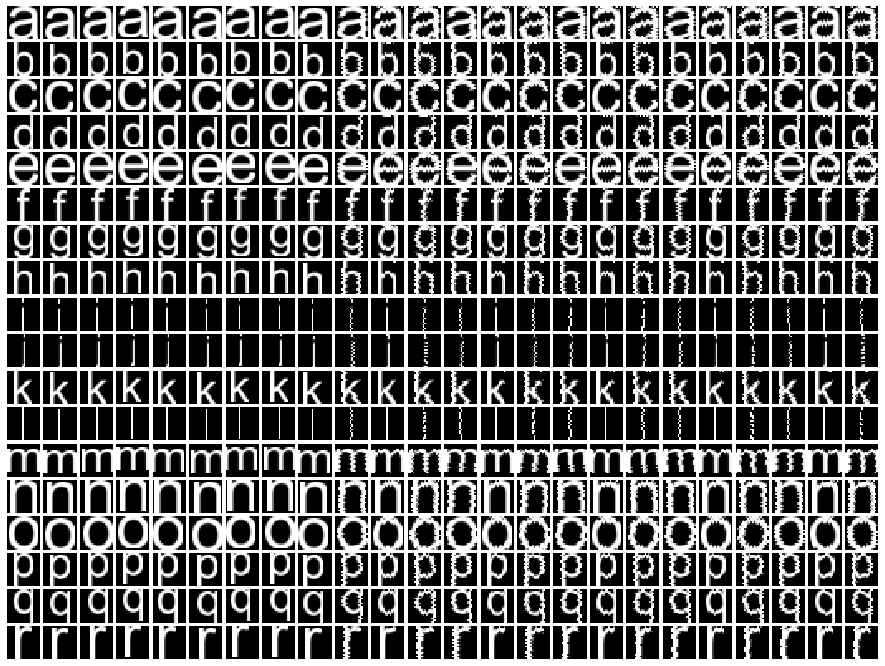

In [259]:
fig = plt.figure(figsize=(21, 12))
letters = np.reshape(X[:18*24], newshape=(18, 24, 20, 20))
tiles(plt.gca(), letters)

## Training models

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

### Random Forest

In [261]:
from sklearn.ensemble import RandomForestClassifier

#### Training

In [262]:
params = {'n_estimators': [50, 100, 200, 400],
          'max_depth': [5, 8, 15, 24, 30, 50, 100],
          'max_features': ['auto', 20, 50, 100, 200]
         }

grid = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  3.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [263]:
grid.best_score_

0.9790419525226154

In [264]:
grid.best_params_

{'max_depth': 50, 'max_features': 50, 'n_estimators': 400}

##### Test set

In [265]:
accuracy_score(grid.best_estimator_.predict(X_test), y_test)

0.9900990099009901

#### Application

In [266]:
# parameters from grid.best_params_ (If you restart kernel, you'll lose that variable)
# so I typed in them directly
rfclf = RandomForestClassifier(n_estimators=400, max_features=50, max_depth=50, n_jobs=-1)
rfclf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=50,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [267]:
img = draw_text(original_text, 'arial')

In [268]:
text = ocr_ml(img, rfclf)
print(text)

t6e mj g6ty dnj egeg goags and 6ej j ows,
t6e wj nd j n angeg 6owj s and gaves,
down to t6e ggound j t 6ends t6e wj j j ows,
and mountaj n-6j g6 j j 8s ug t6e waves.
t6e gaj e-oced moon gj cked out t6j s moment
to geek out fgom 6e6j nd a cj oud,
j j ke a canoe ugon t6e ocean
j t fj gst tj gs ug, and t6en dj gs down.
t6e cocks don't cgowto wake t6e mognj ng,
t6ege' s not as yet a sound of man,
t6e owj s j n gj ades caj j out t6ej g wagnj ngs,
and as6 tgees cgeak and cgeak agaj n.


### KNN Classifier

In [310]:
from sklearn.neighbors import KNeighborsClassifier

#### Training

In [315]:
params = {'n_neighbors': [3, 5, 7, 11, 13, 17, 21],
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'mahalanobis']
         }

grid = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 117 out of 140 | elapsed:    3.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    3.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'mahalanobis'],
                         'n_neighbors': [3, 5, 7, 11, 13, 17, 21],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [316]:
grid.best_score_

0.9448606641976808

In [317]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}

##### Test set

In [318]:
accuracy_score(grid.best_estimator_.predict(X_test), y_test)

0.9306930693069307

#### Application

In [319]:
# parameters from grid.best_params_ (If you restart kernel, you'll lose that variable)
# so I typed in them directly
knnclf = KNeighborsClassifier(metric='euclidean', n_neighbors=13, 
                              weights='distance', n_jobs=-1)
knnclf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='distance')

In [324]:
img = draw_text(original_text, 'arial')

In [325]:
text = ocr_ml(img, knnclf)
print(text)

the mighty dnieper roars and bellows,
the wind in anger howls and raves,
down to the ground it bends the willows,
and mountain-high lihs up the waves.
the pale-kced moon picked out this moment
to peek out from behind a cloud,
like a canoe upon the ocean
it first tips up, and then dips down.
the cocks don't crow to wake the morning,
there's not as yet a sound of man,
the owls in glades call out their warnings,
and ash trees creak and creak again.


In [328]:
leven.levenshtein(text, original_text)

4

In [326]:
accuracy(text, original_text)

0.991130820399113

Great results for KNN Classifier. Let's test it on the rest of texts a bit later!

### Softmax Logistic Regression

In [269]:
from sklearn.linear_model import LogisticRegression

#### Training

In [270]:
# l1 regularization to set zero weight to boundary pixels
# l2 regularization to make the cost function - convex, so SGD works just fine
params = {'penalty': ['elasticnet'],
          'l1_ratio': [0, 0.15, 0.25, 0.5],
          'C': [1, 3, 6, 10, 15, 20, 50, 100, 400],
          'multi_class': ['multinomial'],
          'solver': ['saga']
         }

grid = GridSearchCV(LogisticRegression(), params, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.4min finished
C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 3, 6, 10, 15, 20, 50, 100, 400],
                         'l1_ratio': [0, 0.15, 0.25, 0.5],
                         'multi_class': ['multinomial'],
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scorin

In [271]:
grid.best_score_

0.952546900613199

In [272]:
grid.best_params_

{'C': 6,
 'l1_ratio': 0,
 'multi_class': 'multinomial',
 'penalty': 'elasticnet',
 'solver': 'saga'}

##### Test set

In [273]:
accuracy_score(grid.best_estimator_.predict(X_test), y_test)

0.9702970297029703

#### Application

In [274]:
# parameters from grid.best_params_ (If you restart kernel, you'll lose that variable)
# so I typed in them directly
softmaxclf = LogisticRegression(C=6, penalty='l2', solver='saga', 
                                multi_class='multinomial', n_jobs=-1)
softmaxclf.fit(X, y)

C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=6, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [275]:
img = draw_text(original_text, 'arial')

In [276]:
text = ocr_ml(img, softmaxclf)
print(text)

the mi ghty dni eper roars and bel l ows,
the wi nd i n anger howl s and raves,
down to the ground i t bends the wi l l ows,
and mountai n-hi gh l i hs up the waves.
the pal e-oced moon pi cked out thi s moment
to peek out from behi nd a cl oud,
l i ke a canoe upon the ocean
i t fi rst ti ps up, and then di ps down.
the cocks don't crowto wake the morni ng,
there' s not as yet a sound of man,
the owl s i n gl ades cal l out thei r warni ngs,
and ash trees creak and creak agai n.


In [277]:
accuracy(text, original_text)

0.9135254988913526

Wow, quite great result for SoftMax. We can see that there's a major flaw in our algorithm, something is wrong with spaces. One might notice, that there are redundant spaces after slim characters. Let's get that fixed! (you can't reproduce the result above, as the problem is fixed already)

In [284]:
text = ocr_ml(img, softmaxclf)
print(text)

the mighty dnieper roars and bellows,
the wind in anger howls and raves,
down to the ground it bends the willows,
and mountain-high lihs up the waves.
the pale-oced moon picked out this moment
to peek out from behind a cloud,
like a canoe upon the ocean
it first tips up, and then dips down.
the cocks don't crow to wake the morning,
there's not as yet a sound of man,
the owls in glades call out their warnings,
and ash trees creak and creak again.


In [289]:
leven.levenshtein(text, original_text)

4

In [285]:
accuracy(text, original_text)

0.991130820399113

---
Let's test other texts we have tested before

In [290]:
original_text = \
"""hello, stranger!
i have a long text
for you to read"""

In [291]:
img = draw_text(original_text, 'arial')

In [292]:
text = ocr_ml(img, softmaxclf)
print(text)

hello, stranger!
i have a long text
mr you to read


In [293]:
leven.levenshtein(text, original_text)

2

In [295]:
accuracy(text, original_text)

0.9607843137254902

---

In [296]:
original_text = \
"""so, we have got a very long text here
i do not know actually what to say here,
but let's pretend it is something smart.
well, i do need to add some extra rows,
so then the text is really big"""

In [297]:
img = draw_text(original_text, 'arial')

In [298]:
text = ocr_ml(img, softmaxclf)
print(text)

so, we have got a ve. long text here
i do not know actually what to say here,
but let's pretend it is something smad.
well, i do need to add some extra rows,
so then the text is really big


In [299]:
leven.levenshtein(text, original_text)

4

In [300]:
accuracy(text, original_text)

0.9789473684210527

---

In [346]:
# 'My Testament' - Taras Shevchenko (Заповіт)
original_text = \
"""when i am dead, bury me
in my beloved ukraine,
my tomb upon a grave mound high
amid the spreading plain,
so that the fields, the boundless steppes,
the dnieper's plunging shore
my eyes could see, my ears could hear
the mighty river roar.
when from ukraine the dnieper bears
into the deep blue sea
the blood of foes ... then will i leave
these hills and fertile fields -
i'll leave them all and fly away
to the abode of god,
and then i'll pray .... but till that day
i nothing know of god.
oh bury me, then rise ye up
and break your heavy chains
and water with the tyrants' blood
the freedom you have gained.
and in the great new family,
the family of the free,
with softly spoken, kindly word
remember also me."""

In [347]:
img = draw_text(original_text, 'arial')

In [348]:
text = ocr_ml(img, softmaxclf)
print(text)

when i am dead, bu. me
in my beloved ukraine,
my tomb upon a grave mound high
amid the spreading plain,
so that the fields, the boundless steppes,
the dnieper's plunging shore
my eyes could see, my ears could hear
the mighty river roar.
when from ukraine the dnieper bears
into the deep blue sea
the blood of ies ... then will i leave
these hills and .dile fields -
i'll leave them all and fly away
to the abode of god,
and then i'll pray .... but till that day
i nothing know of god.
oh bu. me, then rise ye up
and break your heavy chains
and water with the tyrants' blood
the freedom you have gained.
and in the great new omily,
the omily of the free,
with sohly spoken, kindly word
remember also me.


In [349]:
leven.levenshtein(text, original_text)

16

In [350]:
accuracy(text, original_text)

0.9774647887323944

---
Getting back to KNN Classifier, let's test it too!

In [329]:
original_text = \
"""hello, stranger!
i have a long text
for you to read"""

In [330]:
img = draw_text(original_text, 'arial')

In [331]:
text = ocr_ml(img, knnclf)
print(text)

hello, stranger!
i have a long text
kr you to read


In [332]:
leven.levenshtein(text, original_text)

2

In [333]:
accuracy(text, original_text)

0.9607843137254902

---

In [334]:
original_text = \
"""so, we have got a very long text here
i do not know actually what to say here,
but let's pretend it is something smart.
well, i do need to add some extra rows,
so then the text is really big"""

In [335]:
img = draw_text(original_text, 'arial')

In [336]:
text = ocr_ml(img, knnclf)
print(text)

so, we have got a ve1 long text here
i do not know actually what to say here,
but let's pretend it is something smad.
well, i do need to add some extra rows,
so then the text is really big


In [337]:
leven.levenshtein(text, original_text)

4

In [338]:
accuracy(text, original_text)

0.9789473684210527

---

In [351]:
# 'My Testament' - Taras Shevchenko (Заповіт)
original_text = \
"""when i am dead, bury me
in my beloved ukraine,
my tomb upon a grave mound high
amid the spreading plain,
so that the fields, the boundless steppes,
the dnieper's plunging shore
my eyes could see, my ears could hear
the mighty river roar.
when from ukraine the dnieper bears
into the deep blue sea
the blood of foes ... then will i leave
these hills and fertile fields -
i'll leave them all and fly away
to the abode of god,
and then i'll pray .... but till that day
i nothing know of god.
oh bury me, then rise ye up
and break your heavy chains
and water with the tyrants' blood
the freedom you have gained.
and in the great new family,
the family of the free,
with softly spoken, kindly word
remember also me."""

In [352]:
img = draw_text(original_text, 'arial')

In [353]:
text = ocr_ml(img, knnclf)
print(text)

when i am dead, bu1 me
in my beloved ukraine,
my tomb upon a grave mound high
amid the spreading plain,
so that the fields, the boundless steppes,
the dnieper's plunging shore
my eyes could see, my ears could hear
the mighty river roar.
when from ukraine the dnieper bears
into the deep blue sea
the blood of ies ... then will i leave
these hills and jdile fields -
i'll leave them all and fly away
to the abode of god,
and then i'll pray .... but till that day
i nothing know of god.
oh bu1 me, then rise ye up
and break your heavy chains
and water with the tyrants' blood
the freedom you have gained.
and in the great new jmily,
the jmily of the free,
with sohly spoken, kindly word
remember also me.


In [354]:
leven.levenshtein(text, original_text)

16

In [355]:
accuracy(text, original_text)

0.9774647887323944

### Saving the models

In [306]:
import pickle

In [309]:
pickle.dump(softmaxclf, open('softmax.model', 'wb'))

In [344]:
pickle.dump(knnclf, open('knn.model', 'wb'))

## Machine Learning OCR Results

We get very! And I mean VERY interesting results! Just look at both of our models! They get the results with mistakes made in the same places! So, we can be almost sure - that is not because our models are not "smart" enough! 

That is because our heuristic of dividing an image of text into images of characters is not robust enough to variations! I've tested before what images do we get, and I have met one image containing 'ry' from the word 'bury' in the 'My Testament' text, or simply \#4 text. So, there was no empty black row between 'r' and 'y', so the heuristic could not divide them properly. As we can see, there is a mistake in the results of both our models! We don't get 
'bury' in any of them, just 'bu' and some other symbol.

#### Improving dividing algorithm

So, basically, we achieved very high accuracy. It can be even improved by upgrading the dividing algorithm, for example by setting the max-width filter of an image using ```average_width``` variable. Then, if it exceeds one, we can try to divide it properly, the simplest approach is to divide in half and hope that our model will cope with it, the other approach would be granting more centered solutions, but adding also the number of black pixels in vertical, searching for the most empty, but still close to the center point.

The completely other approach would be training a model to classify if we have one character or more, and then using another model, or the same - divide it! In other words, there are plenty of possibilities to handle this situation. The only thing is to implement them and see which one is getting better results. But for now, I am completely satisfied with the models we've got here!

#### Generated data

We've got nicely generated data, which allowed us to achieve great accuracy! The key to this - was the same preprocessing of the cut character. It was slightly different from the downloaded data, so we were getting great results among the training and test datasets, but very poor testing on our data.

The other key was having many fewer possible classes as our output, this made our models more sure about the results they produced (we trained them only on lowercase letters, digits, and some punctuation symbols).

The data we've got could be augmented even more, for example by adding some blur to it, or some random noises, but the dataset we got was enough for our purposes. 

#### Skewness

If we would like to handle skewness, we can use the second algorithm for skewness correction (the one with black gaps), then train a model, which based on our characters claim whether the document is flipped or not. If it is - then flip it again. So we will get a more or less correct angle (close to 0). Then our data can be augmented by a little bit skewed letters (by 0.5-4 degrees for example), so it can still recognize letters. The problem can appear for dividing. Then we will have to use some model, or use another technique - we are using 127 as the threshold for black pixel, we can increase it to a much higher value! Mostly rotation along with true type font will produce a bit darker pixels at the edges of a character, so we will try to consider only the centers of characters. This might not lead to a perfect division, but it at least increases chances for a good one!